In [21]:
### ref: HACT_Numerical_Appendix section 5
import copy
import numpy as np
import jax
import jax.numpy as jnp
import scipy.sparse
import scipy.sparse.linalg
from jax import config
config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

In [22]:
alpha = 0.35 # Production function F = K^alpha * L^(1-alpha) 
delta = 0.1  # Capital depreciation

s = 2
rho = 0.05
Var = 0.07

I = 100
amin = -0.02
amax = 4
a = jnp.linspace(amin,amax,I).reshape((I,1))
da = (amax-amin)/(I-1)

J = 40
zmean = jnp.exp(Var/2)
Corr = 0.9
the = -jnp.log(Corr)
sig2 = 2*the*Var
zmin = zmean*0.8
zmax = zmean*1.2
z = jnp.linspace(zmin,zmax,J).reshape((J,1))
dz = (zmax-zmin)/(J-1)
dz2 = dz**2

aa = a * jnp.ones((I, J))
zz = jnp.ones((I, J)) * z.T

mu = (-the * jnp.log(z) + sig2/2)*z
s2 = sig2*z**2

dt = 0.01

In [23]:
def computechi():
    return -jnp.minimum(mu,0)/dz + s2/(2*dz2)

In [24]:
def computeyy():
    return jnp.minimum(mu,0)/dz - jnp.maximum(mu,0)/dz - s2/dz2

In [25]:
def computezeta():
    return jnp.maximum(mu,0)/dz + s2/(2*dz2)

In [26]:
def constructC():
    zeta = computezeta()
    chi = computechi()
    yy = computeyy()
    updiag = jnp.zeros((I,1))
    for j in range(J):
        updiag = jnp.vstack((updiag, jnp.tile(zeta[j], (I,1))))
    
    centdiag = jnp.tile(chi[0]+yy[0],(I,1))
    for j in range(1,J-1):
        centdiag = jnp.vstack((centdiag, jnp.tile(yy[j], (I,1))))
    centdiag = jnp.vstack((centdiag, jnp.tile(yy[J-1]+zeta[J-1], (I,1))))

    # This will be the lower diagonal of the B_switch
    lowdiag = jnp.tile(chi[1], (I,1))
    for j in range(2,J):
        lowdiag = jnp.vstack((lowdiag, jnp.tile(chi[j], (I,1))))

    # Add up the upper, center, and lower diagonal into a sparse matrix   page 18 matrix C
    Cswitch = scipy.sparse.spdiags(centdiag[:,0], 0, I*J, I*J)\
            + scipy.sparse.spdiags(lowdiag[:,0], -I, I*J, I*J)\
            + scipy.sparse.spdiags(updiag[:,0], I, I*J, I*J)
    return Cswitch

In [27]:
def computeVaf(V):
    Vaf = (V[1:I,:]-V[0:I-1,:])/da
    re = (z + r*amax)**(-s)
    Vaf = jnp.vstack([Vaf,re.reshape((40,))])
    return Vaf

In [28]:
def computeVab(V):    
    Vab = (V[1:I,:]-V[0:I-1,:])/da
    re = (z + r*amin)**(-s) 
    Vab = jnp.vstack([re.reshape((40,)),Vab])
    return Vab

In [29]:
def computesf(Vaf):
    cf = Vaf**(-1/s)
    return zz + r*aa - cf

In [30]:
def computesb(Vab):
    cb = Vab**(-1/s)
    return zz + r*aa - cb

In [31]:
def computec(Vaf,Vab):
    sf = computesf(Vaf)
    sb = computesb(Vab)
    c0 = zz + r*aa
    Va0 = c0**(-s)
    If = jnp.where(sf>0, 1, 0)
    Ib = jnp.where(sb<0, 1, 0)
    I0 = (1-If-Ib)
    Va_Upwind = Vaf*If + Vab*Ib + Va0*I0
    c = Va_Upwind**(-1/s)
    return c

In [32]:
def computeu(c):
    return c**(1-s)/(1-s)

In [33]:
def constructA(Vaf,Vab):
    sf = computesf(Vaf)
    sb = computesb(Vab)
    X = -jnp.minimum(sb,0)/da   
    Y = -jnp.maximum(sf,0)/da + jnp.minimum(sb,0)/da
    Z = jnp.maximum(sf,0)/da
    Z = Z.reshape(-1,order='F')
    A_up = scipy.sparse.spdiags(jnp.concatenate([jnp.array([0]),Z]),1,I*J,I*J)
    Y = Y.reshape(-1,order='F')
    A_diag = scipy.sparse.spdiags(Y, 0, I*J, I*J)
    X = X.reshape(-1,order='F')
    X = jnp.roll(X, -1)
    A_down = scipy.sparse.spdiags(X, -1, I*J, I*J)
    AA = A_down + A_diag + A_up
    Cswitch = constructC()
    A = AA + Cswitch
    return A

In [34]:
def T_withtime(Vaf,Vab,V):
    """ 
    equation:
        rhov(t,a,z) = maxu(c)+v_a(t,a,z)(z+ra-c)+mu(z)v_z(t,a,z)+sigma^2(z)/2v_zz(t,a,z)+v_t(t,a,z)
    scheme:
        (rho+1/dt-A)v^n = u^{n+1}+(1/dt)v^{n+1}
    """
    A = constructA(Vaf,Vab)
    B = (rho+1/dt)*scipy.sparse.eye(I*J)-A
    c = computec(Vaf,Vab)
    u = computeu(c)
    u_stack = u.reshape(-1,order='F')
    V_stack = V.reshape(-1,order='F')
    b = u_stack + V_stack/dt
    v = scipy.sparse.linalg.spsolve(B,b)
    return v

In [35]:
def main_withtime(v,Nt):
    result = np.zeros((Nt,v.shape[0],v.shape[1]))
    result[Nt-1,:,:] = v
    for ti in range(Nt-2,-1,-1):
        Vaf = computeVaf(v)
        Vab = computeVab(v)
        v = T_withtime(Vaf,Vab,v)
        v = v.reshape((I,J), order='F')
        result[ti,:,:] = v
    return result

In [36]:
# ## Terminal condition
# r = 0.048
# v = (zz + r*aa)**(1-s)/(1-s)/rho
# result = main_withtime(v,Nt = 100)

In [37]:
# plt.figure(1)
# for ti in [0, 25, 50 , 75]:
#     plt.plot(a,result[ti,:,-1], label='t=%.f'%ti)
# plt.plot(a,v[:,-1], label='terminal')
# plt.legend()
# plt.xlabel('a')
# plt.title('v(t,a,z=z_end)')
# plt.figure(2)
# for ti in [0, 25, 50 , 75]:
#     plt.plot(z,result[ti,-1,:], label='t=%.f'%ti)
# plt.plot(z,v[-1,:], label='terminal')
# plt.legend()
# plt.xlabel('z')
# plt.title('v(t,a=a_end,z)')

In [38]:
def HJB_T(Vaf,Vab):
    A = constructA(Vaf,Vab)
    B = (rho)*scipy.sparse.eye(I*J) - A
    c = computec(Vaf,Vab)
    u = computeu(c)
    u_stack = u.reshape(-1,order='F')
    v = scipy.sparse.linalg.spsolve(B,u_stack)
    return v.reshape((I,J), order='F')

In [39]:
def Fokker(Vaf,Vab):
    """
    AT@g =0
    """
    AT = (constructA(Vaf,Vab).T).todense()
    b = np.zeros((I*J,1))
    #dirty fix
    i_fix = 0
    b[i_fix] = 0.001
    row = np.concatenate((np.array([1]), np.zeros((I*J-1))))
    AT[i_fix,:] = row
    gg = scipy.sparse.linalg.spsolve(scipy.sparse.csr_matrix(AT), b)
    g_sum = gg@np.ones((I*J))*da*dz
    gg = gg/g_sum
    g = gg.reshape((I,J), order='F')
    return g

下面这一段是：先计算HJB, 然后计算带有时间的Fokker. Fokker设置成 在(50,30)处值很大, 其余点为0, 并且g@np.ones((I*J))*da*dz=1. g初值不影响最后的结果.

In [40]:
## solve HJB
### initial condition of v
r = 0.048
v = (zz + r*aa)**(1-s)/(1-s)/rho
iteration = 100
for iter in range(iteration):
        Vaf = computeVaf(v)
        Vab = computeVab(v)
        if iter == iteration-1 or jnp.max(jnp.abs(v-HJB_T(Vaf,Vab)))<1e-6:
            print(jnp.max(jnp.abs(v-HJB_T(Vaf,Vab))))
            v = HJB_T(Vaf,Vab)
            break
        v = HJB_T(Vaf,Vab)
Vaf = computeVaf(v)
Vab = computeVab(v)

### solve Fokker
### initial condition of g
g = np.zeros_like(v)
g[50,30] = (1/da)*(1/dz)
g_initial = copy.deepcopy(g)


"""  
(g^{n+1}-g^{n})/dt = AT@g^{n+1}
g^{n+1}@(I-dt*AT)=g^n
"""
AT = (constructA(Vaf,Vab).T)
C = scipy.sparse.eye(I*J)-AT
C = scipy.sparse.csr_matrix(C)

tmin = 0
tmax = 100
Nt = 100
t = np.linspace(tmin,tmax,Nt)
dt = t[1]-t[0]
g = g.reshape(-1,order='F')
for ti in t:
    print(ti)
    g = scipy.sparse.linalg.spsolve(C,g)

g = g.reshape((I,J),order='F')


1.6436164429478595e-08
0.0
1.0101010101010102
2.0202020202020203
3.0303030303030303
4.040404040404041
5.050505050505051
6.0606060606060606
7.070707070707071
8.080808080808081
9.090909090909092
10.101010101010102
11.111111111111112
12.121212121212121
13.131313131313131
14.141414141414142
15.151515151515152
16.161616161616163
17.171717171717173
18.181818181818183
19.191919191919194
20.202020202020204
21.212121212121215
22.222222222222225
23.232323232323235
24.242424242424242
25.252525252525253
26.262626262626263
27.272727272727273
28.282828282828284
29.292929292929294
30.303030303030305
31.313131313131315
32.323232323232325
33.333333333333336
34.343434343434346
35.35353535353536
36.36363636363637
37.37373737373738
38.38383838383839
39.3939393939394
40.40404040404041
41.41414141414142
42.42424242424243
43.43434343434344
44.44444444444445
45.45454545454546
46.46464646464647
47.47474747474748
48.484848484848484
49.494949494949495
50.505050505050505
51.515151515151516
52.525252525252526
53.5

In [41]:
def main_linear(v,iteration):
    ## HJB-equation
    for iter in range(iteration):
        Vaf = computeVaf(v)
        Vab = computeVab(v)
        if iter == iteration-1 or jnp.max(jnp.abs(v-HJB_T(Vaf,Vab)))<1e-6:
            print(jnp.max(jnp.abs(v-HJB_T(Vaf,Vab))))
            v = HJB_T(Vaf,Vab)
            break
        v = HJB_T(Vaf,Vab)
    ##  AT =  constructA(Vaf,Vab).T
    ## Fokker-eq....
    g = Fokker(Vaf,Vab)  
    return v,g

In [42]:
# ## initial guess v(a,z)
# K = 3.8 
# r = alpha     * K**(alpha-1) -delta
# v = (zz + r*aa)**(1-s)/(1-s)/rho

In [43]:
# iteration = 50
# relax = 0.99
# for iter in range(iteration):
#     print("--------------------------------main iteration --------------------------------")
#     v,g = main_linear(v,30)
#     S = np.sum(g.T@a*da*dz)
#     print("K^{n+1}-K^{n}: ", np.abs(relax*K +(1-relax)*S-K))
#     # update prices
#     K = relax*K +(1-relax)*S           # relaxation algorithm (to ensure convergence)
#     r = alpha     * K**(alpha-1) -delta # interest rates

Text(0.5, 0.5, 'z')

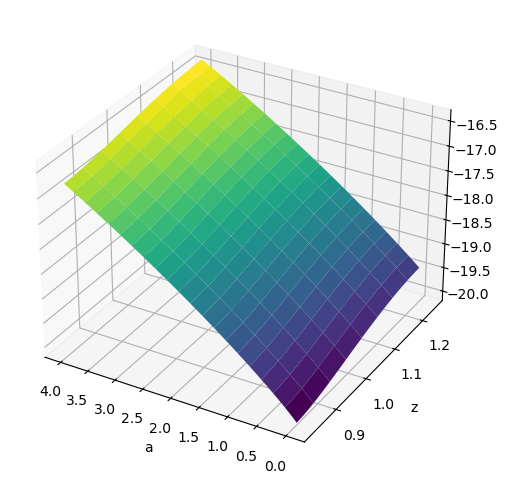

In [44]:
fig1 = plt.figure(figsize=(8, 6), dpi=100)
ax = fig1.add_subplot(111, projection='3d')
A_plot,Z_plot = np.meshgrid(a, z)
ax.invert_xaxis()
surface = ax.plot_surface(A_plot, Z_plot, v.T, cmap='viridis', rstride=5, cstride=5, alpha=1, antialiased=True)
ax.set_xlabel('a')
ax.set_ylabel('z')

Text(0.5, 0.5, 'z')

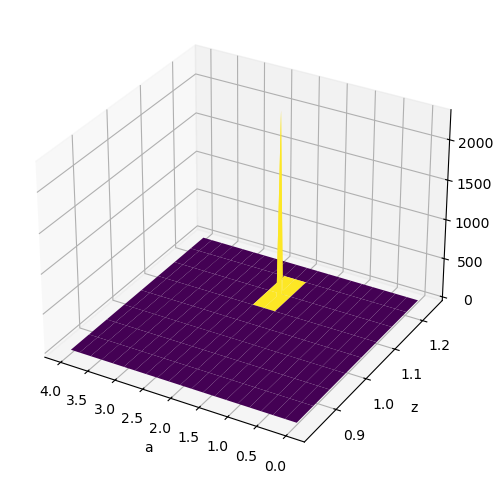

In [45]:
fig1 = plt.figure(figsize=(8, 6), dpi=100)
ax = fig1.add_subplot(111, projection='3d')
A_plot,Z_plot = np.meshgrid(a, z)
ax.invert_xaxis()
surface = ax.plot_surface(A_plot, Z_plot, g_initial.T, cmap='viridis', rstride=5, cstride=5, alpha=1, antialiased=True)
ax.set_xlabel('a')
ax.set_ylabel('z')

Text(0.5, 0.5, 'z')

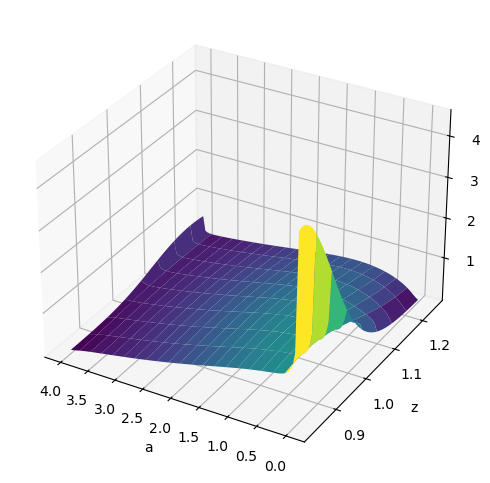

In [46]:
fig1 = plt.figure(figsize=(8, 6), dpi=100)
ax = fig1.add_subplot(111, projection='3d')
A_plot,Z_plot = np.meshgrid(a, z)
ax.invert_xaxis()
surface = ax.plot_surface(A_plot, Z_plot, g.T, cmap='viridis', rstride=5, cstride=5, alpha=1, antialiased=True)
ax.set_xlabel('a')
ax.set_ylabel('z')